In [1]:
%load_ext autoreload
%autoreload 2

import glob
import os
import pynwb
import graph
from tqdm import tqdm
from pathlib import Path 
from itertools import combinations

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

# Utility Functions

In [2]:
import collections

def movmean(A, w):
    """
    Calculates the moving mean of a matrix or vector horizontally.

    Args:
        A (np.array): The input matrix or vector. It must be <= 2 dimensions.
        w (int or list or ndarray): The window size for calculating the moving mean.
            If it is an integer, it calculates a centered window of size w around each element.
            If it is a 2-element list or ndarray, it calculates the window w1 elements before and w2 elements after.

    Returns:
        np.array: The moving mean of the input matrix or vector.
    """

    if A.ndim > 2:
        print("Error: input matrix cannot exceed 2 dimensions")
    elif A.ndim <= 1:
        A = A.reshape(1, -1)
    n = A.shape[1]
    if isinstance(w, (collections.abc.Sequence, np.ndarray)):
        params = [w[0], w[1]]
    else:
        params = [w, w]

    weight_matrix = np.tril(np.triu((np.ones([n, n])), -params[1]), params[0])
    return np.dot(A, weight_matrix)/weight_matrix.sum(axis=0)


from matplotlib.colors import LinearSegmentedColormap
def interpolate_colors(color1, color2, num_colors):
    """
    Interpolates a list of colors between two given colors.

    Parameters:
    color1 (str or tuple): The starting color, can be a name or an RGB tuple.
    color2 (str or tuple): The ending color, can be a name or an RGB tuple.
    num_colors (int): The number of colors to generate between color1 and color2.

    Returns:
    list: A list of interpolated colors in RGBA format.
    """
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1, color2], N=num_colors)
    colors = [cmap(i) for i in range(num_colors)]
    return colors


def xy(node, nrows, ncols):
    """
    Transforms the node identity into X, y coordinates
    :param node: (int) node ID
    :param nrows: (int) number of rows
    :param ncols: (int) number of columns
    :return: (X, Y): (tuple) pair of XY coords
    """
    X = int(node % nrows)
    Y = int(np.floor(node / ncols))
    return X, Y

In [5]:
c1 = "#fc0303" # red
c2 = "#d000ff" # purple
c3 = "#0800ff" # blue
c4 = "#03b6fc" # cyan

caxis_1 = interpolate_colors(c1, c2, 4)
caxis_2 = interpolate_colors(c3, c4, 4)
cmap_2d = np.array([interpolate_colors(caxis_1[i], caxis_2[i], 4) for i in range(4)])

In [7]:
sz1 = 12
sz2 = 18
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [9]:
def get_spike_table(nwbfile, region, epoch, query="", window_size=0, unit_params = {"drift": 2, "min_fr": 1}):
    """_summary_

    Returns:
        (np.array, pd.DataFrame) : spike table aligned to the specified epoch, dataframe with step metadata
        
    """
    assert epoch in nwbfile.intervals.keys(), f"Epoch {epoch} not found in nwbfile intervals. Available epochs: {nwbfile.intervals.keys()}"
    
    assert region in ["HPC", "OFC"], f"Region {region} not found. Available regions: ['HPC', 'OFC']"
    
    unitNames = nwbfile.units.to_dataframe()
    # get good units
    unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
    
    unitNames = unitNames.iloc[unit_idx, :].reset_index(drop=True)
    
    # subsample an epoch with a specific query
    if query == "":
        df = nwbfile.intervals[epoch].to_dataframe()#["timeseries"]
    else:
        df = nwbfile.intervals[epoch].to_dataframe().query(query)#["timeseries"]

    neural_timeseries_index = 0
    
    epoch_win_size = df["window_size"].values[0]
    sample_index = df.index
    spikes = np.zeros((len(sample_index), epoch_win_size*2, len(unit_idx)), dtype=np.float32)
    print("Building Spike Table")
    if window_size != 0:
        for i, _sample in tqdm(enumerate(sample_index)):
            sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
            sample_data = movmean(sample_data.T, window_size).T
            spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
    else:
        for i, _sample in tqdm(enumerate(sample_index)):
            sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
            spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
            
    df = graph.append_use_tele(df)
    return spikes, df, unitNames

In [11]:
def combine_data(DATA_DIR,region,epoch,query):
    
    # combine all sessions

    os.chdir(DATA_DIR)
    filenames = glob.glob('*.nwb')
        
    df = pd.DataFrame()
    spikes = [[] for i in range(len(filenames))]
    neuron_df = pd.DataFrame()
    
    for ii, filename in enumerate(filenames):
        
        nwbfile = pynwb.NWBHDF5IO(filename, "r").read()
        temp_spikes, temp_df, _ = get_spike_table(nwbfile, region, epoch, query, window_size=0)
        temp_df['Session'] = ii
        df = pd.concat([df,temp_df])
        spikes[ii] = temp_spikes
    
        n_cell = temp_spikes.shape[2]
        neuron_df_temp = pd.DataFrame({'Session': np.ones(n_cell)*ii, 'ID': np.arange(n_cell)})
        neuron_df = pd.concat([neuron_df,neuron_df_temp])
    
    df['prenode'] = np.insert(df.node.values[:-1], 0, -1)
    df['postnode'] = np.insert(df.node.values[1:], -1, -1)
    df.loc[df.step==0,'prenode'] = -1
    df.loc[df.step==df.nsteps,'postnode'] = -1

    return df, spikes, neuron_df

In [13]:
DATA_DIR = Path('/Volumes/Extreme SSD')
FIG_DIR = Path('/Users/lianghexin/Documents/Berkeley/Teleworld/Figures')

In [15]:
choice_df, choice_spikes, neuron_df = combine_data(DATA_DIR,"HPC","action_on","trialerror == 0")
# choice_df.drop('timeseries',axis=1).to_csv('choice_df.csv')

Building Spike Table


1499it [00:01, 1354.06it/s]


Building Spike Table


1860it [00:01, 1238.18it/s]


Building Spike Table


2067it [00:01, 1360.67it/s]


Building Spike Table


2278it [00:01, 1454.14it/s]


Building Spike Table


2452it [00:01, 1312.24it/s]


Building Spike Table


2093it [00:01, 1531.47it/s]


In [14]:
choice_df = pd.read_csv('choice_df.csv')

In [16]:
beh = choice_df[['trial', 'step', 'trialerror', 'nsteps',
       'start', 'target', 'block', 'blocktrialnumber', 'node', 
       'graph_distance', 'spatial_distance', 'nodes',
        'use_tele', 'Session', 'prenode', 'postnode']].copy()

In [1067]:
def plot_graph(df,var):
    
    plt.figure(figsize=(6, 6))
    
    for node in np.arange(0, 16):
        
        idx = df.node.values == node
        x, y = xy(node, 4, 4)
        plt.scatter(x, y, s=1000, color = cmap_2d[x, y])
        plt.text(x, y, str(node), fontsize=15, ha='center', va='center', color='w')

        node_df = df[df.node==node]

        for prenode,freq in node_df[['prenode',var]].values:

            x_pre, y_pre = xy(prenode, 4, 4)
            
            if var!='trans_freq':
                freq = freq/7

            if x==x_pre:
                if y>y_pre:
                    plt.arrow(x_pre+0.1, y_pre+0.2, x-x_pre, y-y_pre-0.5, width=freq, color='k')
                else:
                    plt.arrow(x_pre-0.1, y_pre-0.2, x-x_pre, y-y_pre+0.5, width=freq, color='k')

            if y==y_pre:
                if x>x_pre:
                    plt.arrow(x_pre+0.2, y_pre+0.1, x-x_pre-0.5, y-y_pre, width=freq, color='k')
                else:
                    plt.arrow(x_pre-0.2, y_pre-0.1, x-x_pre+0.5, y-y_pre, width=freq, color='k')   

        

    plt.xlim([-0.5, 3.5])
    plt.ylim([-0.5, 3.5])
    plt.xticks([0, 1, 2, 3], labels = ["", "", "", ""])
    plt.yticks([0, 1, 2, 3], labels = ["", "", "", ""])
    
    ax = plt.gca()
    ax.invert_yaxis()  # Invert the y-axis
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    sns.despine(left=True, bottom=True)
    

In [347]:
def create_grid(n,barriers=[],teleports=[]):

    # create n*n grid, transition matrix
    T = np.zeros((n*n,n*n))
    block = np.diag(np.ones(n-1), k=1) + np.diag(np.ones(n-1), k=-1)
    
    for c in range(n):
        T[c*n:(c+1)*n,c*n:(c+1)*n] = block
        cols = np.arange(c, n*n, n)  
        row_idx, col_idx = np.meshgrid(cols, cols, indexing='ij')  # shape (4, 4)
        T[row_idx, col_idx] = block

    if len(barriers)>0:
        for barrier in barriers:
            T[barrier[0],barrier[1]]=0
            T[barrier[1],barrier[0]]=0

    if len(teleports)>0:
        for teleport in teleports:
            T[teleport[0],teleport[1]]=1
            T[teleport[1],teleport[0]]=1  
    
    return T

In [347]:
def create_grid(n,barriers=[],teleports=[]):

    # create n*n grid, transition matrix
    T = np.zeros((n*n,n*n))
    block = np.diag(np.ones(n-1), k=1) + np.diag(np.ones(n-1), k=-1)
    
    for c in range(n):
        T[c*n:(c+1)*n,c*n:(c+1)*n] = block
        cols = np.arange(c, n*n, n)  
        row_idx, col_idx = np.meshgrid(cols, cols, indexing='ij')  # shape (4, 4)
        T[row_idx, col_idx] = block

    if len(barriers)>0:
        for barrier in barriers:
            T[barrier[0],barrier[1]]=0
            T[barrier[1],barrier[0]]=0

    if len(teleports)>0:
        for teleport in teleports:
            T[teleport[0],teleport[1]]=1
            T[teleport[1],teleport[0]]=1  
    
    return T


def distance_matrix(T):
    
    # calculate distance 
    n_state = T.shape[0]
    D=np.zeros((n_state,n_state))
    step=0
    connected = np.eye(n_state)
    nsteps = np.eye(n_state)

    if np.sum(T.mean(axis=0)==0)>0:

        D = np.nan    # check if all the nodes are reachable

    else:
    
        while connected.mean()<1:
        
            step=step+1
            nsteps = np.dot(nsteps,T)*(1-connected)
        
            D[nsteps>0]=step
            connected[nsteps>0]=1

    return D

In [22]:
def distance_matrix(T):
    
    # calculate distance 
    n_state = T.shape[0]
    D=np.zeros((n_state,n_state))
    step=0
    connected = np.eye(n_state)
    nsteps = np.eye(n_state)

    if np.sum(T.mean(axis=0)==0)>0:

        D = np.nan    # check if all the nodes are reachable

    else:
    
        while connected.mean()<1:
        
            step=step+1
            nsteps = np.dot(nsteps,T)*(1-connected)
        
            D[nsteps>0]=step
            connected[nsteps>0]=1

    return D

In [168]:
T = create_grid(4,teleports=[[0,15]])
edges = np.array(np.where(np.triu(T)==1))
grid = distance_matrix(T)

In [224]:
# for each edge, how frequently it is visited for a specific target, how many trajectories are affected if removed

edge_df = pd.DataFrame(data={'edge':list(zip(edges[0],edges[1]))})
edge_diff = np.zeros((edges.shape[1],4))

for index in range(edges.shape[1]):
    
    barrier = edges[:,index].astype(int)
    T_barrier = create_grid(4,[barrier])
    rows, cols = np.where(T_barrier==1)
    D_barrier = distance_matrix(T_barrier)
    edge_diff[index,:] = np.sum((D_barrier-grid)>0,axis=1)[np.array([1, 7, 8, 14])]

# transition frequency for all targets
temp = beh.query("prenode>-1").copy()
temp['edge'] = temp.apply(lambda row: tuple(sorted([row['node'], row['prenode']])), axis=1)
temp['trans_freq'] = temp.groupby(['edge']).transform('size')/len(temp)
transitions = temp[['edge','trans_freq']].drop_duplicates()
edge_df = edge_df.merge(transitions, on=['edge'], how='left')
edge_df = edge_df.rename(columns={'trans_freq': 'trans_freq_all'})

# transition frequency for each target
for target in [1,7,8,14]:

    temp = beh.query("(prenode>-1) & (target==@target)").copy()
    temp['edge'] = temp.apply(lambda row: tuple(sorted([row['node'], row['prenode']])), axis=1)
    temp['trans_freq'] = temp.groupby(['edge']).transform('size')/len(temp)
    transitions = temp[['edge','trans_freq']].drop_duplicates()
    
    edge_df = edge_df.merge(transitions, on=['edge'], how='left')
    edge_df = edge_df.rename(columns={'trans_freq': 'trans_freq'+str(target)})


# edge_df = pd.DataFrame(data={'node1':edges[0],'node2':edges[1],'dis_diff':edge_diff.astype(int)})
edge_df['entropy'] = stats.entropy(edge_df.iloc[:,-4:].values,axis=1)

In [1027]:
edge_df

,edge,trans_freq_all,trans_freq1,trans_freq7,trans_freq8,trans_freq14,entropy
0,"(0, 1)",0.060959,0.164557,0.040331,0.007071,0.032258,0.933372
1,"(0, 4)",0.031540,0.047468,0.003102,0.058586,0.014977,1.069335
2,"(0, 15)",0.059634,0.069620,0.034126,0.032323,0.108295,1.260874
3,"(1, 2)",0.053273,0.137131,0.054809,0.012121,0.006912,0.906315
4,"(1, 5)",0.038961,0.128692,0.003102,0.017172,0.005760,0.598115
5,"(2, 3)",0.026504,0.031646,0.066184,0.004040,0.002304,0.860477
6,"(2, 6)",0.024119,0.054852,0.021717,0.004040,0.016129,1.088388
7,"(3, 7)",0.037636,0.007384,0.110651,0.002020,0.029954,0.752403
8,"(4, 5)",0.027829,0.027426,0.018614,0.055556,0.006912,1.168203
9,"(4, 8)",0.053273,0.040084,0.002068,0.157576,0.005760,0.668889


In [ ]:
col_names = [f'col_{i}' for i in range(n)]
df[col_names] = arr
edge_diff

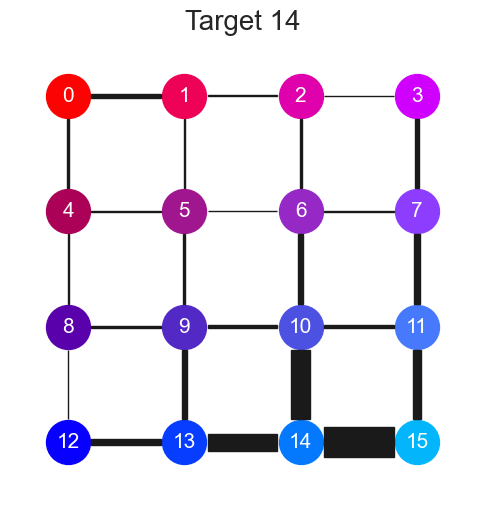

In [317]:
for target in [1,7,8,14]:
    
    plt.close('all')
    plt.figure(figsize=(6, 6))
    
    for node in range(16):
    
        x, y = xy(node, 4, 4)
        plt.scatter(x, y, s=1000, color = cmap_2d[x, y])
        plt.text(x, y, str(node), fontsize=15, ha='center', va='center', color='w')
        
    
    for (prenode, node),freq  in edge_df[['edge','trans_freq%i'%target]].values:
        
        x, y = xy(node, 4, 4)
        x_pre, y_pre = xy(prenode, 4, 4)    
        freq=freq*1.2
    
        if x==x_pre:
            if y>y_pre:
                plt.arrow(x_pre, y_pre+0.2, x-x_pre, y-y_pre-0.4, width=freq, color='k',head_width=0)
            else:
                plt.arrow(x_pre, y_pre-0.2, x-x_pre, y-y_pre+0.4, width=freq, color='k',head_width=0)
    
        if y==y_pre:
            if x>x_pre:
                plt.arrow(x_pre+0.2, y_pre, x-x_pre-0.4, y-y_pre, width=freq, color='k',head_width=0)
            else:
                plt.arrow(x_pre-0.2, y_pre, x-x_pre+0.4, y-y_pre, width=freq, color='k',head_width=0)   
    
        
    plt.xlim([-0.5, 3.5])
    plt.ylim([-0.5, 3.5])
    plt.xticks([0, 1, 2, 3], labels = ["", "", "", ""])
    plt.yticks([0, 1, 2, 3], labels = ["", "", "", ""])
    
    ax = plt.gca()
    ax.invert_yaxis()  # Invert the y-axis
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    sns.despine(left=True, bottom=True)
    plt.title('Target %i'%target,fontsize=20)
    plt.savefig('Transition frequency, target %i'%target)

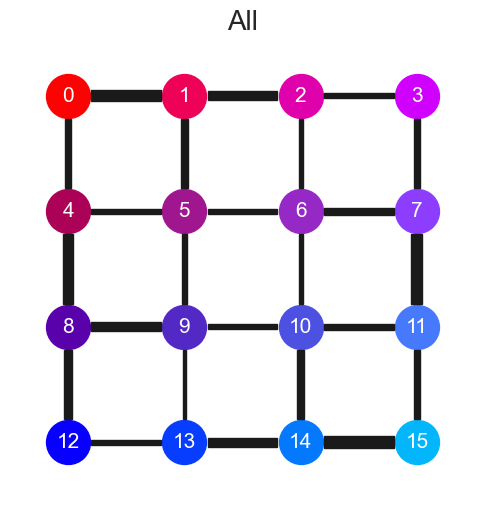

In [983]:
plt.close('all')
plt.figure(figsize=(6, 6))

for node in range(16):

    x, y = xy(node, 4, 4)
    plt.scatter(x, y, s=1000, color = cmap_2d[x, y])
    plt.text(x, y, str(node), fontsize=15, ha='center', va='center', color='w')
    

for (prenode, node),freq  in edge_df[['edge','trans_freq_all']].values:
    
    x, y = xy(node, 4, 4)
    x_pre, y_pre = xy(prenode, 4, 4)    
    freq=freq*1.5

    if x==x_pre:
        if y>y_pre:
            plt.arrow(x_pre, y_pre+0.2, x-x_pre, y-y_pre-0.4, width=freq, color='k',head_width=0)
        else:
            plt.arrow(x_pre, y_pre-0.2, x-x_pre, y-y_pre+0.4, width=freq, color='k',head_width=0)

    if y==y_pre:
        if x>x_pre:
            plt.arrow(x_pre+0.2, y_pre, x-x_pre-0.4, y-y_pre, width=freq, color='k',head_width=0)
        else:
            plt.arrow(x_pre-0.2, y_pre, x-x_pre+0.4, y-y_pre, width=freq, color='k',head_width=0)   

    
plt.xlim([-0.5, 3.5])
plt.ylim([-0.5, 3.5])
plt.xticks([0, 1, 2, 3], labels = ["", "", "", ""])
plt.yticks([0, 1, 2, 3], labels = ["", "", "", ""])

ax = plt.gca()
ax.invert_yaxis()  # Invert the y-axis
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
sns.despine(left=True, bottom=True)
plt.title('All',fontsize=20)
plt.savefig('Transition frequency all')

In [1109]:
transitions.query("prenode<2")

,prenode,node,trans_freq,in_trial,edge
10,0,15,0.033395,0.269067,"(0.0, 15.0)"
49,0,1,0.051418,0.381940,"(0.0, 1.0)"
50,1,2,0.014047,0.120195,"(1.0, 2.0)"
58,0,4,0.015637,0.262965,"(0.0, 4.0)"
172,1,5,0.006096,0.158633,"(1.0, 5.0)"
216,1,0,0.009541,0.158633,"(0.0, 1.0)"


In [1099]:
both_dir

,edge,prenode,node,trans_freq,in_trial
0,"(0.0, 1.0)",1,1,0.060959,0.540574
1,"(0.0, 4.0)",4,4,0.031540,0.485052
2,"(0.0, 15.0)",15,15,0.059634,0.532642
3,"(1.0, 2.0)",3,3,0.053273,0.439902
4,"(1.0, 5.0)",6,6,0.038961,0.525320
5,"(2.0, 3.0)",5,5,0.026504,0.297743
6,"(2.0, 6.0)",8,8,0.024119,0.413057
7,"(3.0, 7.0)",10,10,0.037636,0.384991
8,"(4.0, 5.0)",9,9,0.027829,0.433801
9,"(4.0, 8.0)",12,12,0.053273,0.448444


Text(0.5, 1.0, 'All')

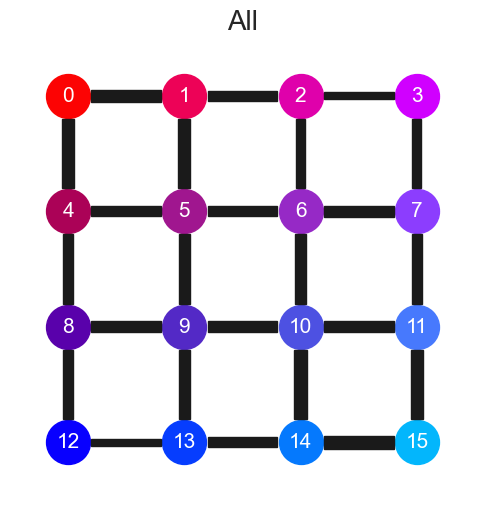

In [1119]:
plt.close('all')
plt.figure(figsize=(6, 6))

for node in range(16):

    x, y = xy(node, 4, 4)
    plt.scatter(x, y, s=1000, color = cmap_2d[x, y])
    plt.text(x, y, str(node), fontsize=15, ha='center', va='center', color='w')
    

for (prenode, node),freq  in both_dir[['edge','in_trial']].values:
    
    x, y = xy(node, 4, 4)
    x_pre, y_pre = xy(prenode, 4, 4)    
    freq=freq*0.2

    if x==x_pre:
        if y>y_pre:
            plt.arrow(x_pre, y_pre+0.2, x-x_pre, y-y_pre-0.4, width=freq, color='k',head_width=0)
        else:
            plt.arrow(x_pre, y_pre-0.2, x-x_pre, y-y_pre+0.4, width=freq, color='k',head_width=0)

    if y==y_pre:
        if x>x_pre:
            plt.arrow(x_pre+0.2, y_pre, x-x_pre-0.4, y-y_pre, width=freq, color='k',head_width=0)
        else:
            plt.arrow(x_pre-0.2, y_pre, x-x_pre+0.4, y-y_pre, width=freq, color='k',head_width=0)   

    
plt.xlim([-0.5, 3.5])
plt.ylim([-0.5, 3.5])
plt.xticks([0, 1, 2, 3], labels = ["", "", "", ""])
plt.yticks([0, 1, 2, 3], labels = ["", "", "", ""])

ax = plt.gca()
ax.invert_yaxis()  # Invert the y-axis
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
sns.despine(left=True, bottom=True)
plt.title('All',fontsize=20)
# plt.savefig('Transition frequency all')

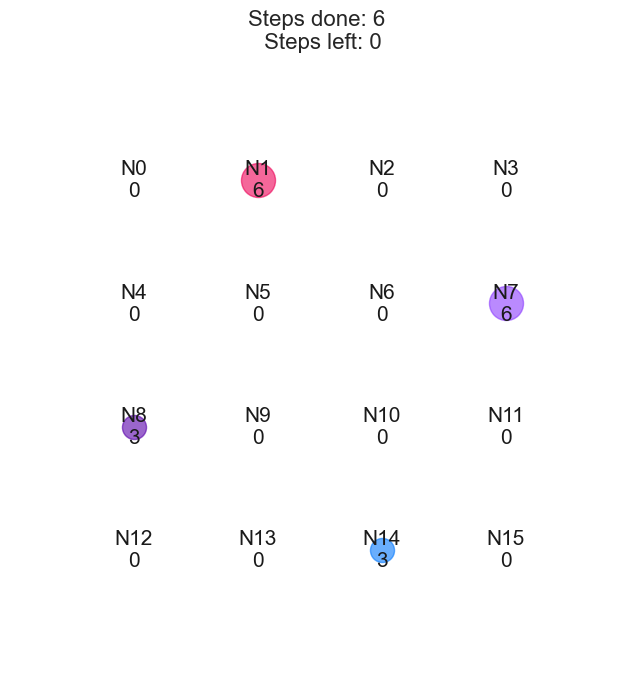

In [1385]:
choice_df['steps2go']=choice_df['nsteps']-choice_df['step']
node_step = choice_df[['node','step','steps2go']].copy()
node_step['counts'] = node_step.groupby(['step','steps2go']).transform('size')
node_step = node_step.query('counts>5')

for step, steps2go in node_step[['step','steps2go']].drop_duplicates().values:

    plt.close('all')
    plt.figure(figsize=(8,8))
    
    node_count = node_step.query('(step==@step)&(steps2go==@steps2go)').groupby('node').size()
    arr = np.zeros(16)
    arr[node_count.index.values] = node_count.values
    
    for node in range(16):
    
        x, y = xy(node, 4, 4)
        plt.scatter(x, y, s=arr[node]*100, color = cmap_2d[x, y],alpha=0.6)
        plt.text(x, y, ('N%i\n%i' % (node,arr[node])), fontsize=15, ha='center', va='center', color='k')
    
    plt.xlim(-1,4)
    plt.ylim(-1,4)
    plt.title('Steps done: %i \n Steps left: %i' % (step,steps2go),fontsize=16)
    
    ax = plt.gca()
    ax.invert_yaxis()  # Invert the y-axis
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    sns.despine(left=True, bottom=True)
    
    plt.savefig('Steps done %i, Steps left %i' % (step,steps2go))

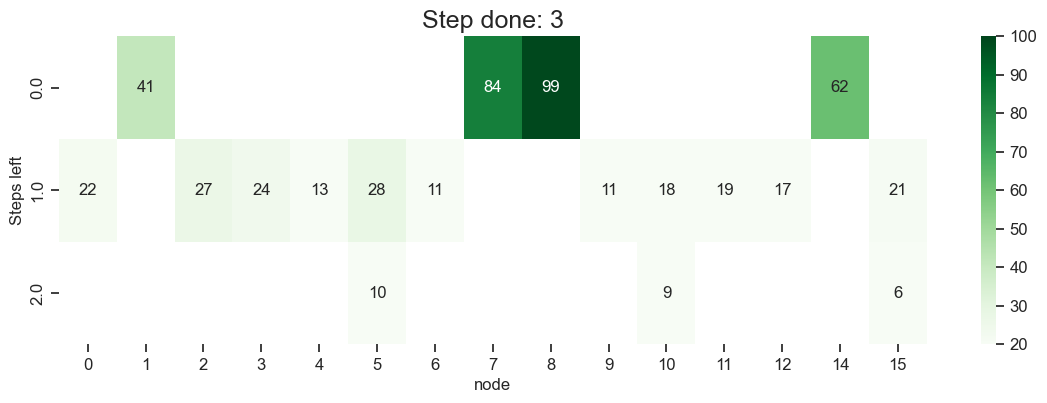

In [1457]:
node_stepdone = choice_df[['node','step','steps2go']].copy()
node_stepdone['counts'] = node_stepdone.groupby(['step','node','steps2go']).transform('size')
node_stepdone = node_stepdone.query('counts>5')

for step in range(4):

    a = node_stepdone.query('(step==@step) & (steps2go<5)').drop_duplicates().pivot(index="steps2go", columns="node", values="counts")
    
    plt.close('all')
    plt.figure(figsize=(14,4))
    sns.heatmap(data=a,annot=True,cmap=sns.color_palette("Greens", as_cmap=True),fmt='.0f',vmin=20,vmax=100)
    plt.ylabel('Steps left')
    plt.title('Step done: %i' % step,fontsize=18)
    plt.savefig('Step done %i, nodes and steps2go heatmap' % step)

In [27]:
choice_df.Session.unique()

array([0, 1, 2, 3, 4, 5])

In [ ]:
choice_df['steps2go']=choice_df['nsteps']-choice_df['step']


In [33]:
a = node_step.query('node==@node').drop_duplicates().pivot(index="steps2go", columns="step", values="counts")

In [35]:
a

step,0,1,2,3,4,5,6,7,11,12,13
steps2go,,,,,,,,,,,
1.0,102.0,152.0,39.0,41.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN
2.0,150.0,136.0,31.0,13.0,3.0,2.0,NaN,NaN,1.0,1.0,NaN
3.0,46.0,10.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
4.0,64.0,5.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
5.0,8.0,2.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0
6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
7.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
9.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
a.reindex(index=np.arange(5), columns=np.arange(5)).to_numpy()

array([[ nan,  nan,  nan,  nan,  nan],
       [102., 152.,  39.,  41.,   3.],
       [150., 136.,  31.,  13.,   3.],
       [ 46.,  10.,   4.,   1.,   1.],
       [ 64.,   5.,   1.,  nan,   1.]])

In [63]:
# for each node, look at the number of choices for each combination of steps done * steps left

sessions = choice_df.Session.unique()
node_step = np.zeros((16,len(sessions),5,5))

for ss in sessions:

    df = choice_df.query('Session==@ss')[['node','step','steps2go']].copy()
    df['counts'] = df.groupby(['step','node','steps2go']).transform('size')
    
    for node in range(16):
        
        temp = df.query('node==@node').drop_duplicates().pivot(index="steps2go", columns="step", values="counts")
        node_step[node,ss,:,:] = temp.reindex(index=np.arange(5), columns=np.arange(5)).to_numpy()

for node in range(16):

    plt.close('all')
    plt.figure(figsize=(5,4))
    sns.heatmap(data=np.nanmean(node_step[node,:,:,:],axis=0),annot=True,cmap=sns.color_palette("Greens", as_cmap=True),fmt='.0f',vmin=0,vmax=20)
    plt.ylabel('Steps left')
    plt.xlabel('Step done')
    plt.title('Node: %i' % node,fontsize=18)
    plt.savefig('Node %i, Step done and steps2go heatmap' % node)

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_31422/1774221752.py:17: RuntimeWarning: Mean of empty slice
  sns.heatmap(data=np.nanmean(node_step,axis=0),annot=True,cmap=sns.color_palette("Greens", as_cmap=True),fmt='.0f',vmin=0,vmax=25)
/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_31422/1774221752.py:17: RuntimeWarning: Mean of empty slice
  sns.heatmap(data=np.nanmean(node_step,axis=0),annot=True,cmap=sns.color_palette("Greens", as_cmap=True),fmt='.0f',vmin=0,vmax=25)
/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_31422/1774221752.py:17: RuntimeWarning: Mean of empty slice
  sns.heatmap(data=np.nanmean(node_step,axis=0),annot=True,cmap=sns.color_palette("Greens", as_cmap=True),fmt='.0f',vmin=0,vmax=25)


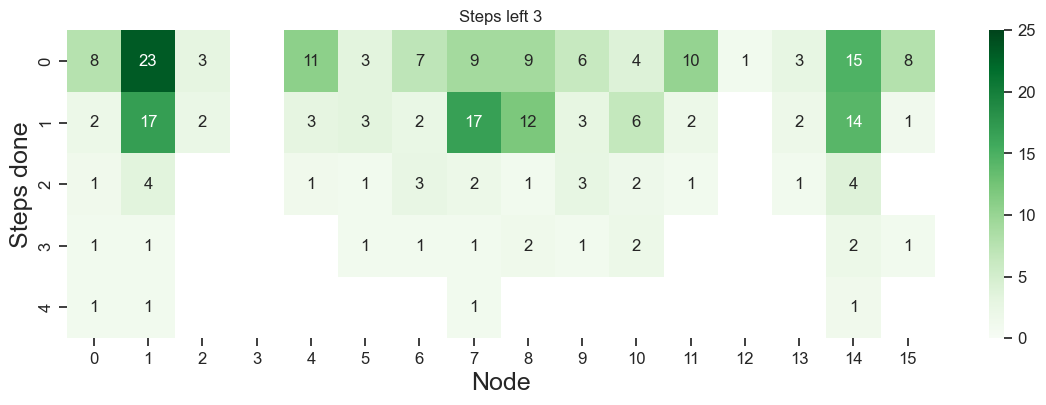

In [145]:

for ii in range(1,4):

    node_step = np.zeros((len(sessions),5,16))
    
    
    for ss in sessions:
    
        df = choice_df.query('(Session==@ss) & (steps2go==@ii)')[['node','step']].copy()
        df['counts'] = df.groupby(['step','node']).transform('size')
            
        temp = df.drop_duplicates().pivot(index="step", columns="node", values="counts")
        node_step[ss,:,:] = temp.reindex(index=np.arange(5), columns=np.arange(16)).to_numpy()
    
    
    plt.close('all')
    plt.figure(figsize=(14,4))
    sns.heatmap(data=np.nanmean(node_step,axis=0),annot=True,cmap=sns.color_palette("Greens", as_cmap=True),fmt='.0f',vmin=0,vmax=25)
    plt.ylabel('Steps done',fontsize=18)
    plt.xlabel('Node',fontsize=18)
    plt.title('Steps left %i' % ii)
    plt.savefig('Node and Step, session average, steps left %i' % ii)

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_31422/990207381.py:14: RuntimeWarning: Mean of empty slice
  sns.heatmap(data=np.nanmean(node_step,axis=0),annot=True,cmap=sns.color_palette("Greens", as_cmap=True),fmt='.0f',vmin=0,vmax=50)


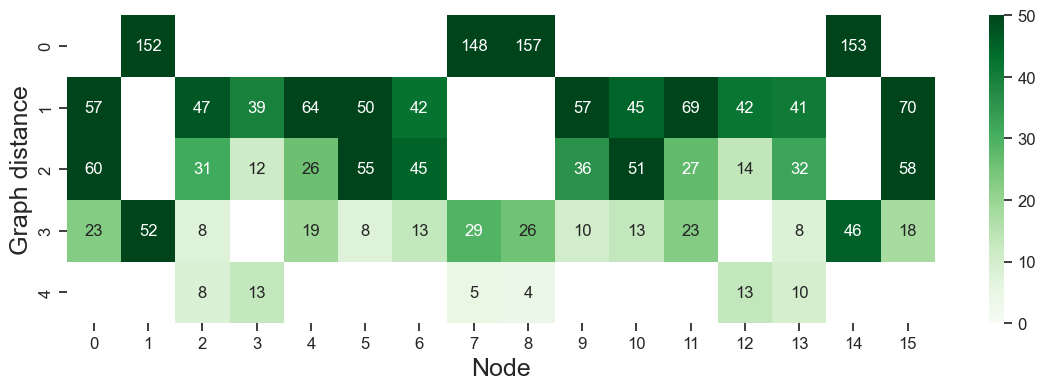

In [119]:
node_step = np.zeros((len(sessions),5,16))

for ss in sessions:

    df = choice_df.query('Session==@ss')[['node','graph_distance']].copy()
    df['counts'] = df.groupby(['graph_distance','node']).transform('size')
        
    temp = df.drop_duplicates().pivot(index="graph_distance", columns="node", values="counts")
    node_step[ss,:,:] = temp.reindex(index=np.arange(5), columns=np.arange(16)).to_numpy()


plt.close('all')
plt.figure(figsize=(14,4))
sns.heatmap(data=np.nanmean(node_step,axis=0),annot=True,cmap=sns.color_palette("Greens", as_cmap=True),fmt='.0f',vmin=0,vmax=50)
plt.ylabel('Graph distance',fontsize=18)
plt.xlabel('Node',fontsize=18)
plt.savefig('Node and Graph distance, session average')

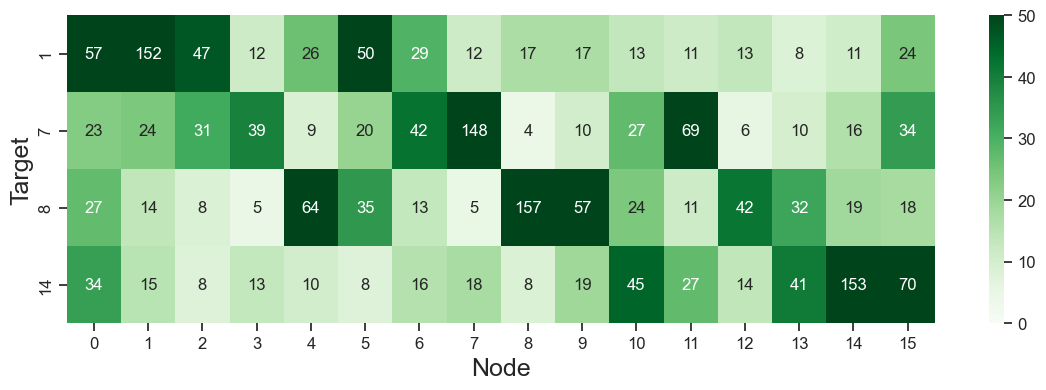

In [129]:
node_step = np.zeros((len(sessions),4,16))

for ss in sessions:

    df = choice_df.query('Session==@ss')[['node','target']].copy()
    df['counts'] = df.groupby(['target','node']).transform('size')
        
    temp = df.drop_duplicates().pivot(index="target", columns="node", values="counts")
    node_step[ss,:,:] = temp.reindex(index=[1,7,8,14], columns=np.arange(16)).to_numpy()


plt.close('all')
plt.figure(figsize=(14,4))
sns.heatmap(data=np.nanmean(node_step,axis=0),annot=True,cmap=sns.color_palette("Greens", as_cmap=True),fmt='.0f',vmin=0,vmax=50)
plt.yticks([0.5,1.5,2.5,3.5],labels=[1,7,8,14])
plt.ylabel('Target',fontsize=18)
plt.xlabel('Node',fontsize=18)
plt.savefig('Node and target, session average')

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_31422/2307718137.py:14: RuntimeWarning: Mean of empty slice
  sns.heatmap(data=np.nanmean(node_step,axis=0),annot=True,cmap=sns.color_palette("Greens", as_cmap=True),fmt='.0f',vmin=0,vmax=50)


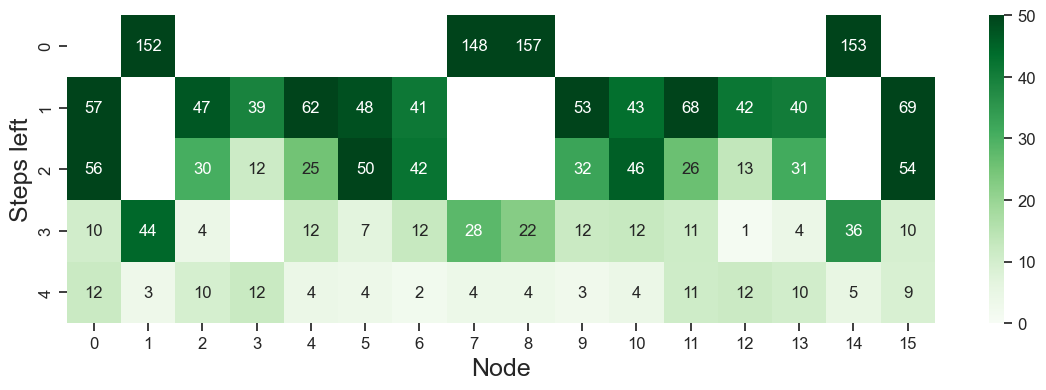

In [117]:
node_step = np.zeros((len(sessions),5,16))

for ss in sessions:

    df = choice_df.query('Session==@ss')[['node','steps2go']].copy()
    df['counts'] = df.groupby(['steps2go','node']).transform('size')
        
    temp = df.drop_duplicates().pivot(index="steps2go", columns="node", values="counts")
    node_step[ss,:,:] = temp.reindex(index=np.arange(5), columns=np.arange(16)).to_numpy()


plt.close('all')
plt.figure(figsize=(14,4))
sns.heatmap(data=np.nanmean(node_step,axis=0),annot=True,cmap=sns.color_palette("Greens", as_cmap=True),fmt='.0f',vmin=0,vmax=50)
plt.ylabel('Steps left',fontsize=18)
plt.xlabel('Node',fontsize=18)
plt.savefig('Node and Steps2go, session average')

In [1029]:
trial_df = choice_df[['trial','start','target','nodes','use_tele']].drop_duplicates()

Text(0.5, 1.0, 'Target 1')

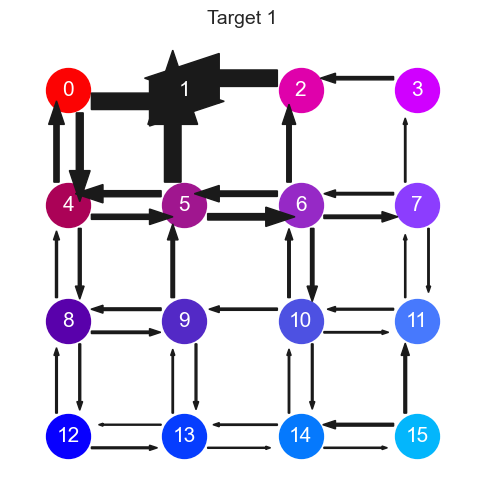

In [1143]:
# edge in trial

target=1
temp = beh.query("(prenode>-1)&(target==@target)").copy()
temp['trans_count'] = temp.groupby(['node','prenode']).transform('size')  
temp['trans_freq'] = temp['trans_count']/len(temp)
transitions = temp[['prenode','node','trans_freq']].drop_duplicates()

trial_df_temp = trial_df.query("target==@target").copy()

edge_in_trial = np.zeros((len(transitions),len(trial_df_temp)))

for ii in range(len(transitions)):

    edge = transitions.iloc[ii][['prenode','node']].values

    for tt in range(len(trial_df_temp)):

        trajectory = np.fromstring(trial_df_temp.iloc[tt].nodes,dtype=int, sep=',')

        windows = np.lib.stride_tricks.sliding_window_view(trajectory, 2)
        
        # Compare each window to B, row-wise
        edge_in_trial[ii,tt] = np.any(windows == edge)

transitions['in_trial'] = edge_in_trial.mean(axis=1)
# transitions.sort_values(by=['in_trial'],ascending=False)
transitions['edge'] = transitions.apply(lambda row: tuple(sorted([row['prenode'], row['node']])), axis=1)
plt.close('all')
plot_graph(transitions,'in_trial')
# plot_graph(transitions.query("(node!=1) & (node!=7) & (node!=8) & (node!=14)"),'in_trial')

plt.title('Target %i' % target,fontsize=14)

In [1083]:

# transitions['trans_freq'] = transitions.groupby(['edge']).transform('size')/len(temp)

# transitions[['edge','in_trial']].drop_duplicates()

In [1095]:
both_dir = transitions.groupby('edge').sum().reset_index()

In [1087]:
transitions[['prenode','node','in_trial']].sort_values(by=['in_trial'],ascending=False)

,prenode,node,in_trial
49,0,1,0.381940
18,10,14,0.381330
20,15,14,0.377059
70,5,1,0.366687
6,6,7,0.353264
34,9,8,0.352654
37,4,8,0.337401
55,13,14,0.334960
39,12,8,0.321538
64,2,1,0.319707


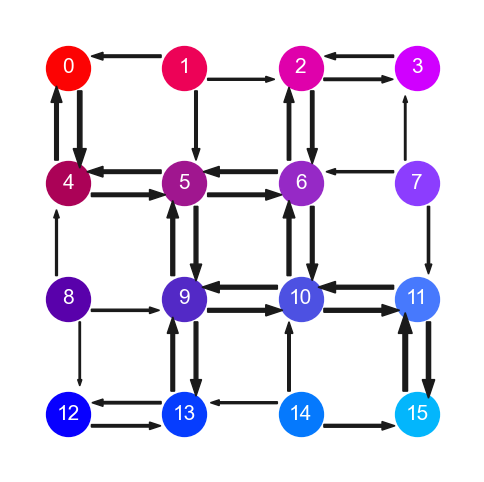

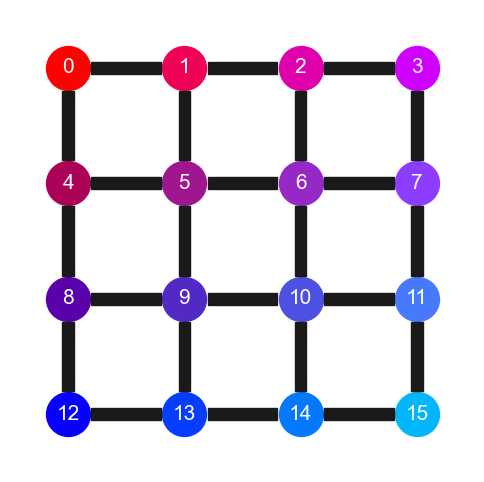

In [569]:
teleports = [[0,15]]

grid = create_grid(4,teleports=teleports)

distance = distance_matrix(T)

plot_graph_fromT(T)

In [739]:
def get_policy(transition,distance):

    policy = np.zeros((16,16,5))  # multiple actions might be right, need to code it in separate columns
    # notes = np.array(['up','down','left','right','tele'])
    

    for target in range(16):
        
        target_dis = distance[target,:]
    
        for dd in range(int(target_dis.max())):
            
            dd_node = np.where(target_dis==dd+1)[0]
            
            for node in dd_node:
        
                x, y = xy(node, 4, 4)
                dd_prenode = np.where(transition[node,:]*(target_dis==dd))[0]
        
                for prenode in dd_prenode:
                
                    x_pre, y_pre = xy(prenode, 4, 4)    
            
                    if x==x_pre:
                        if y<y_pre:
                            policy[target,node,0]=1   # up
                        else:
                            policy[target,node,1]=1   # down
                    elif y==y_pre:
                        if x<x_pre:
                            policy[target,node,2]=1   # left
                        else:
                            policy[target,node,3]=1   # right
                    else:
                        policy[target,node,4]=1     # tele

    return policy

In [867]:
def plot_graph_fromT(T,ax):

    plt.sca(ax)
    
    for node in range(16):
    
        x, y = xy(node, 4, 4)
        plt.scatter(x, y, s=1000, color = cmap_2d[x, y])
        plt.text(x, y, str(node), fontsize=15, ha='center', va='center', color='w')

    rows, cols = np.where(np.triu(T)==1)
    
    for node, prenode in zip(rows,cols):
        
        x, y = xy(node, 4, 4)
        x_pre, y_pre = xy(prenode, 4, 4)    
        freq=1
    
        if x == x_pre:
            if y > y_pre:
                plt.plot([x_pre, x], [y_pre + 0.2, y - 0.2], 'k--', linewidth=freq)
            else:
                plt.plot([x_pre, x], [y_pre - 0.2, y + 0.2], 'k--', linewidth=freq)
        
        elif y == y_pre:
            if x > x_pre:
                plt.plot([x_pre + 0.2, x - 0.2], [y_pre, y], 'k--', linewidth=freq)
            else:
                plt.plot([x_pre - 0.2, x + 0.2], [y_pre, y], 'k--', linewidth=freq)
 
        else: 
            plt.scatter(x, y, s=1200, facecolors='none', edgecolors='k', lw=2)
    
        
    plt.xlim([-0.5, 3.5])
    plt.ylim([-0.5, 3.5])
    plt.xticks([0, 1, 2, 3], labels = ["", "", "", ""])
    plt.yticks([0, 1, 2, 3], labels = ["", "", "", ""])
    
    ax = plt.gca()
    ax.invert_yaxis()  # Invert the y-axis
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    sns.despine(left=True, bottom=True)


In [897]:
# calculate distance matrix and policy matrix for a certain configuration: teleport + barrier

teleports = [[0,15]]

grid = create_grid(4)
grid_edge = np.array(np.where(np.triu(grid)==1))
indices = np.arange(grid_edge.shape[1])

all_barriers = []
all_transitions = []
all_distances = []
all_policy = []
all_distance_diff = []
all_policy_reduced = []
all_policy_new = []
all_distance_diff_target = []
all_policy_reduced_target = []
all_policy_new_target = []

for combo in combinations(indices, 2):
    
    barriers = [grid_edge[:,combo[0]].astype(int),grid_edge[:,combo[1]].astype(int)]
    transition = create_grid(4,barriers=barriers,teleports=teleports)
    distance = distance_matrix(transition)

    if not np.isscalar(distance):
        
        policy = get_policy(transition,distance)
        distance_diff = distance-default_distance
        reduced = (default_policy-policy)==1
        new = (policy-default_policy)==1

        all_transitions.append(transition)
        all_barriers.append(barriers)
        all_distances.append(distance)
    
        all_policy.append(policy)
        all_distance_diff.append(distance_diff)
        all_policy_reduced.append(reduced)
        all_policy_new.append(new)
        
        all_distance_diff_target.append(np.sum(distance_diff>0,axis=0))
        all_policy_reduced_target.append(np.sum(reduced,axis=(1,2)))
        all_policy_new_target.append(np.sum(new,axis=(1,2)))


env_df = pd.DataFrame(data={'Transitions': all_transitions,
                            'Distances': all_distances,
                            'Policies': all_policy,
                            'Barriers': all_barriers,
                            'Distance_diff': all_distance_diff,
                            'Policy_reduced': all_policy_reduced,
                            'Policy_new': all_policy_new,
                            'Distance_diff_target': all_distance_diff_target,
                            'Policy_reduced_target': all_policy_reduced_target,
                            'Policy_new_target': all_policy_new_target,
})


env_df['Teleports']=teleports*len(env_df)

In [949]:
new_p = np.stack(env_df.Policy_new_target.values)[:,np.array([1,7,8,14])]
red_p = np.stack(env_df.Policy_reduced_target.values)[:,np.array([1,7,8,14])]

In [1149]:
new_p.sum(axis=1)

array([14,  8, 11,  8,  8,  8, 11, 10, 10, 10, 12, 10,  9, 12,  8, 10,  8,
        7, 11,  9,  8,  8, 10,  7,  9,  6,  6,  6,  6,  5,  8,  8, 10,  8,
        8, 10,  6,  8,  6,  6, 10,  8,  6,  7,  9,  9,  2,  4,  2,  3,  6,
        7,  5,  7,  5,  6,  7,  3,  5,  3,  3,  7,  7,  3,  4,  8,  6,  7,
        6,  5,  8,  6,  5,  9,  9,  9,  9,  6,  7,  5,  6, 10, 10,  6,  7,
       11,  3,  2,  5,  4,  4,  6,  4,  5,  6,  2,  4,  2,  2,  6,  6,  2,
        3,  8,  3,  2,  5,  6,  4,  5,  3,  5,  6,  2,  4,  2,  2,  5,  6,
        2,  3,  8,  2,  5,  4,  4,  6,  4,  5,  6,  2,  4,  2,  2,  6,  6,
        2,  3,  8,  5,  3,  6,  5,  4,  5,  6,  2,  4,  2,  2,  6,  6,  2,
        3,  7,  7,  8,  9,  7,  8,  8,  5,  7,  5,  5,  9,  8,  5,  6,  9,
        7,  5,  7,  7,  8,  4,  6,  4,  4,  7,  8,  4,  5, 10,  7,  8,  7,
        6,  4,  7,  3,  4,  9,  8,  4,  5, 10,  6,  8, 10,  6,  8,  6,  6,
        9, 10,  6,  7, 12,  8,  7,  4,  7,  4,  6,  5,  8,  4,  5, 10,  9,
        5,  7,  5,  5,  8

In [1151]:
red_p.sum(axis=1)

array([10, 11, 13, 11, 11, 11, 12, 11, 14, 13, 16, 13, 12, 16, 11, 14, 11,
       10, 14, 10, 11, 11, 10, 10, 13, 10, 10, 10, 10,  9, 12, 13, 14, 13,
       11, 14, 10, 12, 10,  9, 14, 10, 10, 10, 10, 16,  9, 11,  9,  9, 11,
       16, 13, 15, 12, 11, 15, 10, 13, 10,  9, 13, 10, 10, 10, 11, 14, 15,
       14, 12, 14, 15, 13, 18, 17, 15, 18, 13, 16, 12, 13, 18, 14, 13, 13,
       14, 10,  9, 11, 13, 13, 15, 12, 11, 15, 10, 13, 10,  9, 13, 10, 10,
       10, 11, 10,  9, 11, 15, 13, 14, 11, 11, 15, 10, 13, 10,  9, 12, 10,
       10, 10, 11,  9, 11, 13, 13, 15, 12, 11, 15, 10, 13, 10,  9, 13, 10,
       10, 10, 11,  9, 10, 14, 12, 12, 10, 15,  9, 12,  9,  8, 13,  9,  9,
        9, 10, 13, 16, 15, 14, 12, 15, 11, 13, 11, 10, 15, 11, 11, 11, 12,
       15, 14, 17, 13, 19, 13, 18, 13, 12, 16, 12, 13, 13, 14, 17, 16, 14,
       16, 12, 17, 11, 12, 17, 13, 12, 12, 13, 16, 15, 20, 15, 19, 15, 15,
       18, 14, 15, 15, 16, 16, 17, 13, 15, 13, 14, 13, 13, 13, 13, 13, 15,
       11, 13, 11,  9, 14

In [1003]:
sort_id = np.argsort(np.stack(env_df.Policy_new_target.values).sum(axis=1))[::-1]

In [1177]:
mean_dis = env_df['Distances'].apply(lambda x: np.mean(x[x>0])).values

In [1189]:
mean_new_p = env_df['Policy_new'].apply(np.sum).values

In [1209]:
mean_red_p = env_df['Policy_reduced'].apply(np.sum).values

Text(0.5, 1.0, 'New routes')

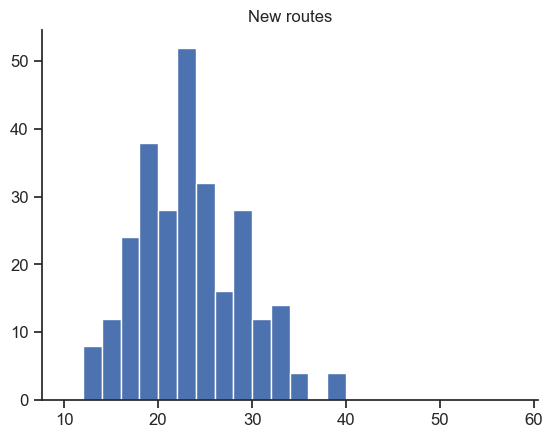

In [1201]:
plt.close('all')
plt.hist(mean_new_p,np.arange(10,60,2))
# plt.axvline(np.mean(default_distance[default_distance>0]),color='r',linestyle='--')
plt.title('New routes')

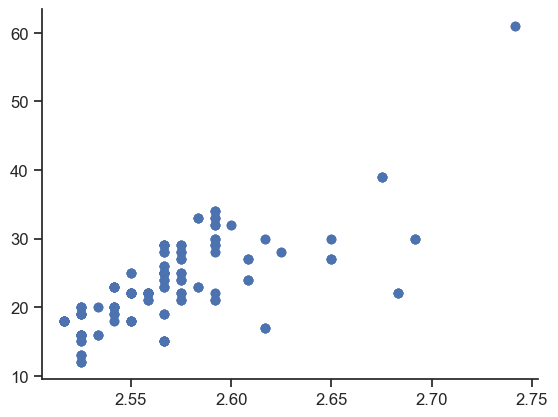

In [1203]:
plt.close('all')
plt.scatter(mean_dis,mean_new_p)

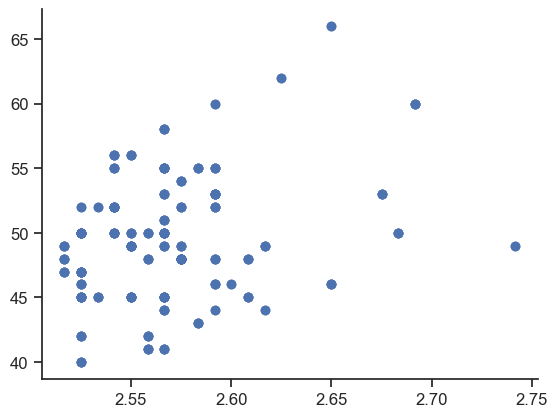

In [1211]:
plt.close('all')
plt.scatter(mean_dis,mean_red_p)

Text(0.5, 1.0, 'Mean path length')

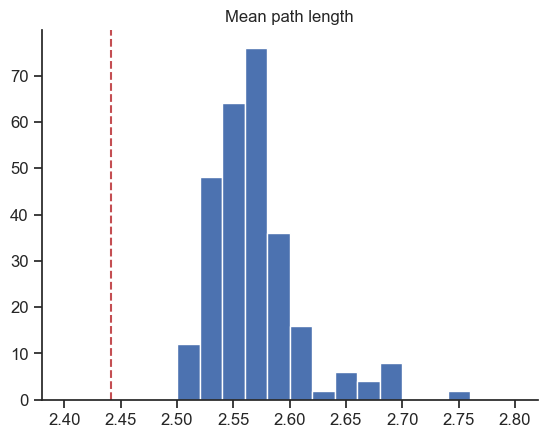

In [1187]:
plt.close('all')
plt.hist(mean_dis,bins=np.linspace(2.4,2.8,21))
plt.axvline(np.mean(default_distance[default_distance>0]),color='r',linestyle='--')
plt.title('Mean path length')

In [1145]:
env_df.iloc[sort_id]

,Transitions,Distances,Policies,Barriers,Distance_diff,Policy_reduced,Policy_new,Distance_diff_target,Policy_reduced_target,Policy_new_target,Teleports
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 6.0, 5.0, 4.0, 6.0, 5.0, 4.0, 3.0, 5.0,...","[[[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 1.0, 0...","[[0, 1], [0, 4]]","[[0.0, 5.0, 3.0, 1.0, 5.0, 3.0, 1.0, 0.0, 3.0,...","[[[False, False, False, False, False], [False,...","[[[False, False, False, False, False], [True, ...","[9, 4, 2, 1, 4, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 5]","[12, 5, 3, 2, 5, 3, 2, 0, 3, 2, 0, 2, 2, 0, 2, 6]","[16, 7, 3, 1, 7, 3, 1, 0, 3, 1, 0, 4, 1, 0, 4,...","[0, 15]"
270,"[[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 2.0, 3.0, 1.0, 2.0, 3.0, 4.0, 2.0,...","[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1...","[[11, 15], [14, 15]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[[[False, False, False, False, False], [False,...","[[[False, False, False, False, False], [False,...","[5, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 4, 1, 2, 4, 9]","[6, 2, 0, 2, 2, 0, 2, 3, 0, 2, 3, 5, 2, 3, 5, 12]","[10, 4, 0, 1, 4, 0, 1, 3, 0, 1, 3, 7, 1, 3, 7,...","[0, 15]"
6,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 5.0, 5.0, 4.0, 1.0, 4.0, 4.0, 3.0, 2.0,...","[[[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0...","[[0, 1], [4, 5]]","[[0.0, 4.0, 3.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0,...","[[[False, False, False, False, False], [False,...","[[[False, False, False, False, False], [True, ...","[5, 5, 3, 2, 6, 3, 2, 1, 0, 0, 0, 1, 0, 0, 1, 3]","[8, 7, 5, 3, 6, 4, 4, 2, 2, 2, 1, 1, 2, 1, 1, 4]","[7, 8, 4, 1, 3, 3, 2, 1, 0, 0, 0, 2, 0, 0, 2, 6]","[0, 15]"
24,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 2.0, 3.0, 5.0, 4.0, 3.0, 3.0, 5.0,...","[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1...","[[0, 4], [1, 5]]","[[0.0, 0.0, 0.0, 0.0, 4.0, 2.0, 0.0, 0.0, 3.0,...","[[[False, False, False, False, False], [False,...","[[[False, False, False, False, False], [False,...","[5, 6, 0, 0, 5, 3, 0, 0, 3, 2, 0, 1, 2, 1, 1, 3]","[8, 6, 2, 2, 7, 4, 2, 1, 5, 4, 1, 1, 3, 2, 1, 4]","[7, 3, 0, 0, 8, 3, 0, 0, 4, 2, 0, 2, 1, 1, 2, 6]","[0, 15]"
264,"[[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 2.0, 3.0, 1.0, 2.0, 3.0, 4.0, 2.0,...","[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1...","[[10, 14], [11, 15]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[[[False, False, False, False, False], [False,...","[[[False, False, False, False, False], [False,...","[3, 1, 1, 2, 1, 0, 2, 3, 0, 0, 3, 5, 0, 0, 6, 5]","[4, 1, 2, 3, 1, 1, 4, 5, 1, 2, 4, 7, 2, 2, 6, 8]","[6, 2, 1, 1, 2, 0, 2, 4, 0, 0, 3, 8, 0, 0, 3, 7]","[0, 15]"
...,...,...,...,...,...,...,...,...,...,...,...
271,"[[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 2.0, 3.0, 1.0, 2.0, 3.0, 3.0, 2.0,...","[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1...","[[12, 13], [13, 14]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[False, False, False, False, False], [False,...","[[[False, False, False, False, False], [False,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 2, 2]","[1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 6, 6, 4, 3]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 2, 2]","[0, 15]"
95,"[[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 2.0, 4.0, 1.0, 2.0, 3.0, 3.0, 2.0,...","[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1...","[[2, 3], [8, 12]]","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[False, False, False, False, False], [False,...","[[[False, False, False, False, False], [False,...","[2, 1, 1, 3, 1, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0]","[2, 3, 3, 6, 3, 2, 2, 2, 3, 2, 2, 2, 6, 2, 2, 0]","[2, 1, 1, 3, 1, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0]","[0, 15]"
130,"[[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 2.0, 3.0, 1.0, 2.0, 3.0, 3.0, 2.0,...","[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1...","[[3, 7], [8, 12]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[False, False, False, False, False], [False,...","[[[False, False, F

In [955]:
idx = np.where(np.sum(new_p>2,axis=1)==2)

In [1025]:
np.corrcoef(new_p[:,2],new_p[:,3])

array([[ 1.       , -0.1756847],
       [-0.1756847,  1.       ]])

Text(0.5, 1.0, 'Default')

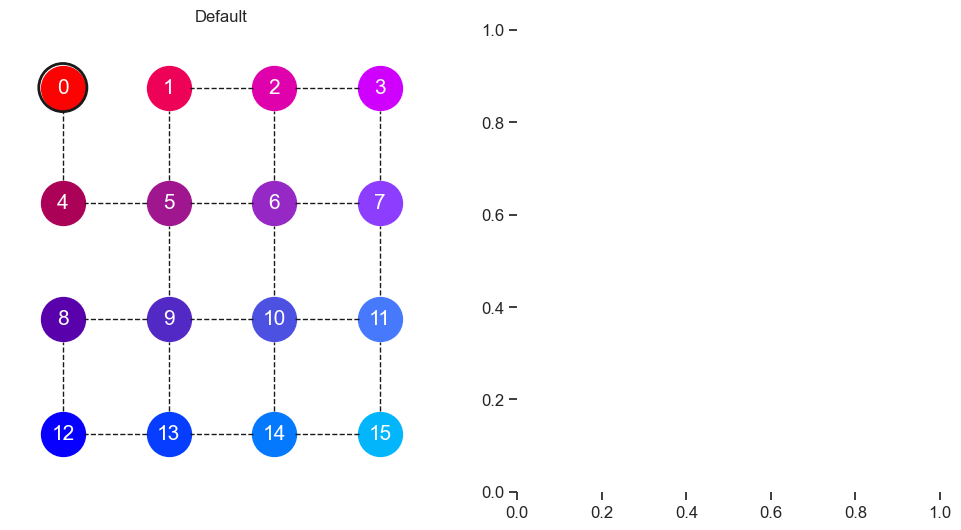

In [947]:
plt.close('all')
fig, ax = plt.subplots(1,2,figsize=(12,6))
plot_graph_fromT(env_df.iloc[7].Transitions,ax[0])
plt.title('Default')

In [763]:
default_transition = create_grid(4,teleports=teleports)
default_distance = distance_matrix(default_transition)
default_policy = get_policy(default_transition,default_distance)

Text(0.5, 1.0, 'Barrier')

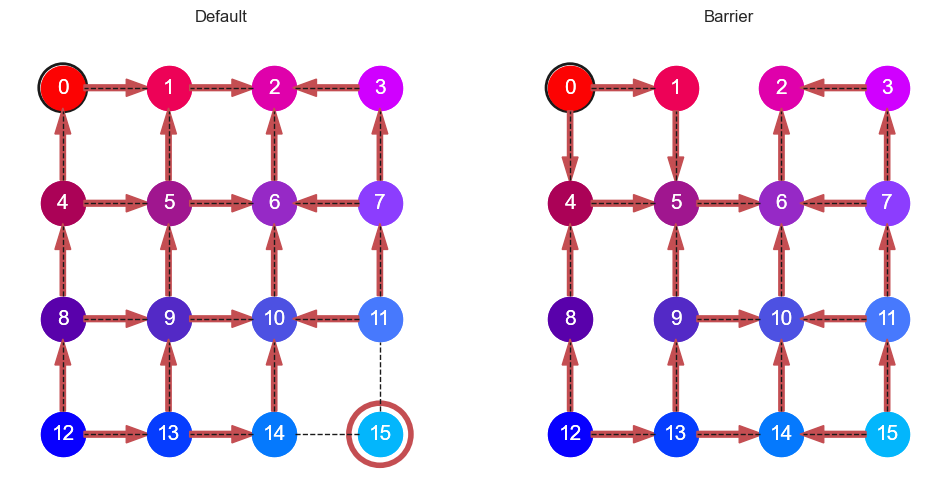

In [869]:
target = 2
plt.close('all')
fig, ax = plt.subplots(1,2,figsize=(12,6))

plot_graph_fromT(default_transition,ax[0])
plot_policy(default_policy[target,:],ax[0])
plt.title('Default')

plot_graph_fromT(transition,ax[1])
plot_policy(policy[target,:],ax[1])
plt.title('Barrier')


In [803]:
new_sol = np.where((policy-default_policy)==1)
new_sol

(array([ 0,  0,  1,  1,  2,  2,  2,  2,  3,  3,  8,  8,  8,  8,  8,  9,  9,
        10, 10, 11, 15, 15]),
 array([ 2,  3,  2,  3,  0,  1, 15, 15,  0,  1,  9,  9, 10, 10, 11,  8,  8,
         8,  8,  8,  2,  2]),
 array([0, 0, 0, 0, 0, 0, 1, 3, 4, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 2]))

In [805]:
reduced_sol = np.where((default_policy-policy)==1)
reduced_sol

(array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 12, 12, 13, 13, 14, 15]),
 array([ 2,  3,  6,  9,  2,  6,  7,  8,  1,  4,  5,  8, 15,  0,  1,  4,  5,
         8,  2,  9,  2,  8,  1,  8,  1,  8,  2,  5,  6,  7,  9, 11, 13, 14,
         2,  4,  8, 12,  1,  4,  8, 12,  8, 12,  2,  9,  2,  8,  8,  2]),
 array([3, 3, 1, 3, 3, 1, 1, 2, 2, 1, 1, 2, 4, 2, 2, 1, 1, 2, 3, 3, 3, 2,
        2, 2, 2, 2, 3, 0, 0, 0, 3, 3, 1, 1, 3, 0, 2, 1, 2, 0, 2, 1, 2, 1,
        3, 3, 3, 2, 2, 3]))

Text(0.5, 1.0, 'Teleport: [0, 15], Barrier: [array([1, 2]), array([8, 9])]')

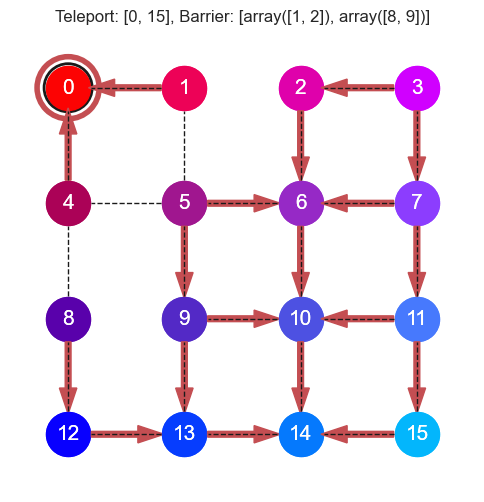

In [811]:
index = 56
target = 14
teleport = env_df.iloc[index].Teleports
barrier = env_df.iloc[index].Barriers
policy = env_df.iloc[index].Policies
transition = env_df.iloc[index].Transitions
distance = env_df.iloc[index].Distances

plot_graph_fromT(transition)
plot_policy(policy[14,:])

plt.title(f'Teleport: {teleport}, Barrier: {barrier}')

In [855]:
def plot_policy(policy,ax,c='r'):

    plt.sca(ax)
    
    for node in range(16):
    
        x, y = xy(node, 4, 4)
        plt.scatter(x, y, s=1000, color = cmap_2d[x, y])
        plt.text(x, y, str(node), fontsize=15, ha='center', va='center', color='w')

        action = np.where(policy[node,:])[0]

        for aa in action:

            match aa:
                case 0:
                    plt.arrow(x, y+0.2, 0, 0.4, width=0.05, color=c)
                case 1:
                    plt.arrow(x, y-0.2, 0, -0.4, width=0.05, color=c)
                case 2:
                    plt.arrow(x+0.2, y, 0.4, 0, width=0.05, color=c)
                case 3:
                    plt.arrow(x-0.2, y, -0.4, 0, width=0.05, color=c)
                case 4:
                    plt.scatter(x, y, s=2000, facecolors='none', edgecolors=c, lw=4)

        
    plt.xlim([-0.5, 3.5])
    plt.ylim([-0.5, 3.5])
    plt.xticks([0, 1, 2, 3], labels = ["", "", "", ""])
    plt.yticks([0, 1, 2, 3], labels = ["", "", "", ""])
    
    ax = plt.gca()
    ax.invert_yaxis()  # Invert the y-axis
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    sns.despine(left=True, bottom=True)


In [333]:
# change two edges

T = create_grid(4,teleports=[[0,15]])
edges = np.array(np.where(np.triu(T)==1))
grid = distance_matrix(T)

indices = np.arange(edges.shape[1])

edge_diff = []
barriers = []

for combo in combinations(indices, 2):
    
    barrier = [edges[:,combo[0]].astype(int),edges[:,combo[1]].astype(int)]
    barriers.append(barrier)

    T_barrier = create_grid(4,barrier,)
    rows, cols = np.where(T_barrier==1)
    D_barrier = distance_matrix(T_barrier)
    edge_diff.append(np.sum((D_barrier-grid)>0)/2)

barriers = np.array(barriers)
edge_diff = np.array(edge_diff)

edges2_df = pd.DataFrame(data={'edge1':list(barriers[:,0,:]),
                               'edge2':list(barriers[:,1,:]),
                               'dis_diff':edge_diff.astype(int)})
edges2_df = edges2_df[edges2_df.dis_diff>0]

In [337]:
edges2_df

,edge1,edge2,dis_diff
1,"[0, 1]","[0, 15]",18
2,"[0, 1]","[1, 2]",20
3,"[0, 1]","[1, 5]",24
4,"[0, 1]","[2, 3]",20
5,"[0, 1]","[2, 6]",21
...,...,...,...
294,"[11, 15]","[12, 13]",21
295,"[11, 15]","[13, 14]",22
297,"[12, 13]","[13, 14]",20
298,"[12, 13]","[14, 15]",20


In [345]:
np.unique(edges2_df.dis_diff.values,return_counts=True)

(array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30]),
 array([16,  8, 24, 78, 82, 34, 24,  4, 14,  2,  4,  6]))

In [216]:
center_edge = edges2_df[(np.all(np.vstack(edges2_df['edge1'].values)==[5,6],axis=1)) | 
            (np.all(np.vstack(edges2_df['edge2'].values)==[5,6],axis=1))] 
center_edge.sort_values(by=['dis_diff'],ascending=False)

,edge1,edge2,dis_diff
51,"[1, 2]","[5, 6]",16
177,"[5, 6]","[9, 10]",16
173,"[5, 6]","[6, 10]",12
171,"[5, 6]","[5, 9]",12
179,"[5, 6]","[10, 11]",9
175,"[5, 6]","[8, 9]",9
8,"[0, 1]","[5, 6]",9
108,"[2, 6]","[5, 6]",9
90,"[2, 3]","[5, 6]",9
71,"[1, 5]","[5, 6]",9


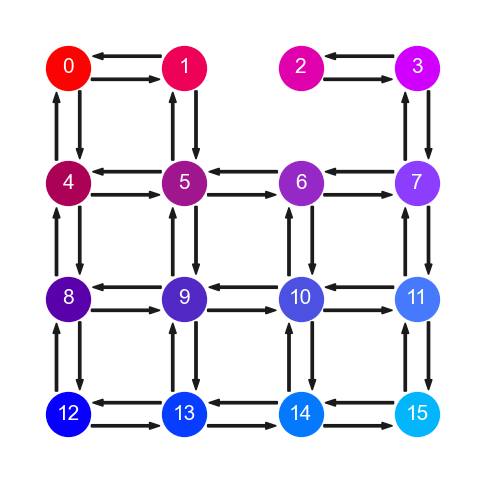

In [48]:
index = 46
barrier = edges2_df.iloc[index][['edge1','edge2']].values
T_barrier = create_grid(4,barrier)
rows, cols = np.where(T_barrier==1)
df = pd.DataFrame(data={'prenode':rows,'node':cols})
df['trans_freq']=0.02
plot_graph(df)

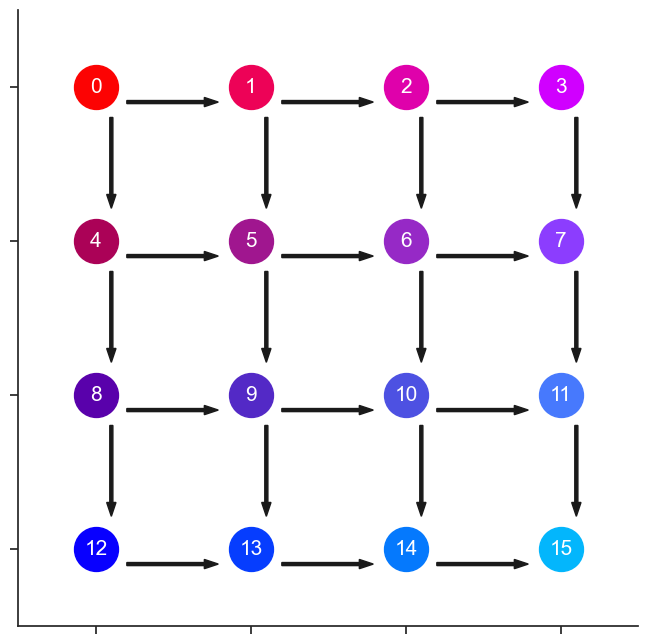

In [171]:
T = create_grid(4)
rows, cols = np.where(np.triu(T)==1)
edges = pd.DataFrame(data={'prenode':rows,'node':cols})
edges['trans_freq']=0.02
plot_graph(edges)

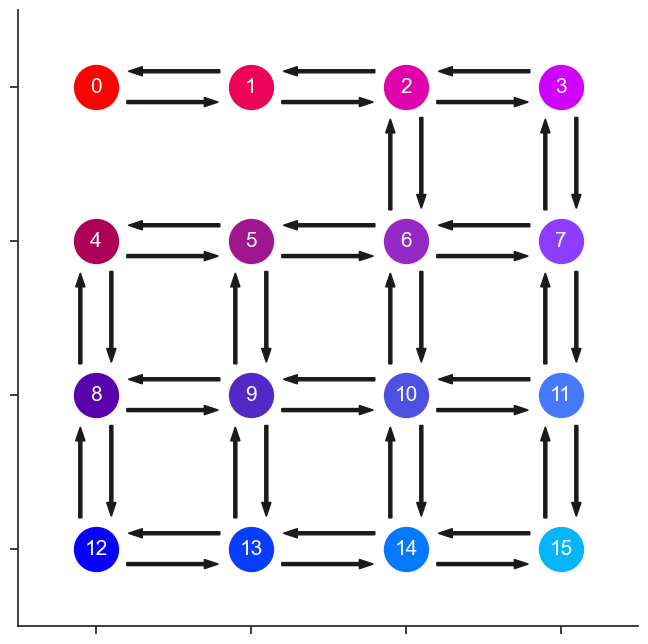

In [157]:
T = create_grid(4,[[0,4],[1,5]])
rows, cols = np.where(T==1)
df = pd.DataFrame(data={'prenode':rows,'node':cols})
df['trans_freq']=0.02
plot_graph(df)

In [230]:
transitions.sort_values(by='trans_freq',ascending=False)

,prenode,node,trans_freq
id,,,
24,15,14,0.058309
5,11,7,0.054068
55,0,1,0.051418
40,9,8,0.043732
43,4,8,0.042937
45,12,8,0.041346
72,2,1,0.039226
61,13,14,0.037106
26,3,7,0.035781


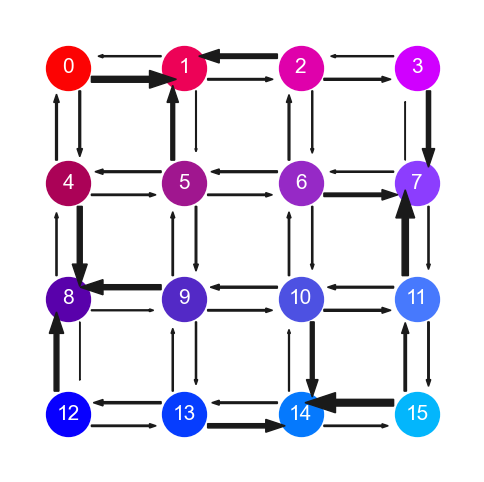

In [228]:
temp = beh.query("prenode>-1").copy()
temp['trans_count'] = temp.groupby(['node','prenode']).transform('size')  
temp['trans_freq'] = temp['trans_count']/len(temp)
transitions = temp[['prenode','node','trans_freq']].drop_duplicates()
plot_graph(transitions)

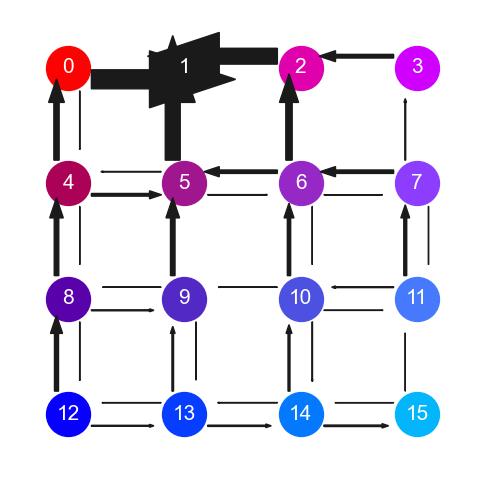

In [232]:
temp = beh.query("(prenode>-1)&(target==1)").copy()
temp['trans_count'] = temp.groupby(['node','prenode']).transform('size')  
temp['trans_freq'] = temp['trans_count']/len(temp)
transitions = temp[['prenode','node','trans_freq']].drop_duplicates()
plot_graph(transitions)

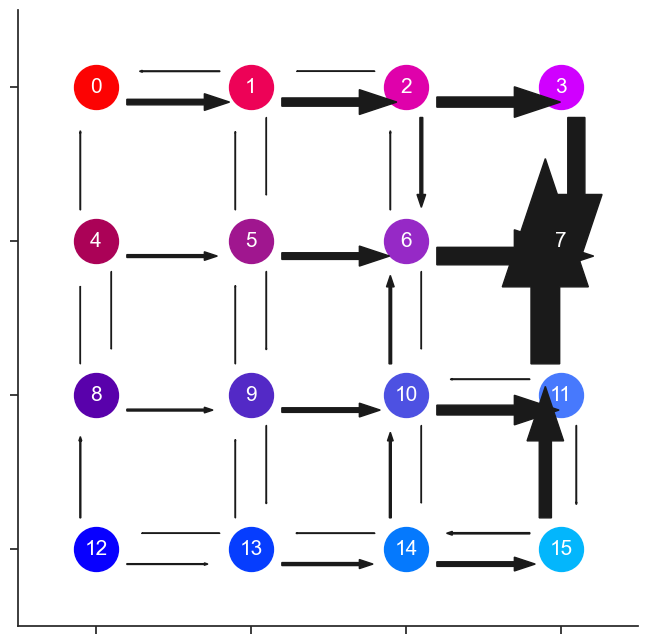

In [123]:
temp = beh.query("(prenode>-1)&(target==7)").copy()
temp['trans_count'] = temp.groupby(['node','prenode']).transform('size')  
temp['trans_freq'] = temp['trans_count']/len(temp)
transitions = temp[['prenode','node','trans_freq']].drop_duplicates()
plot_graph(transitions)

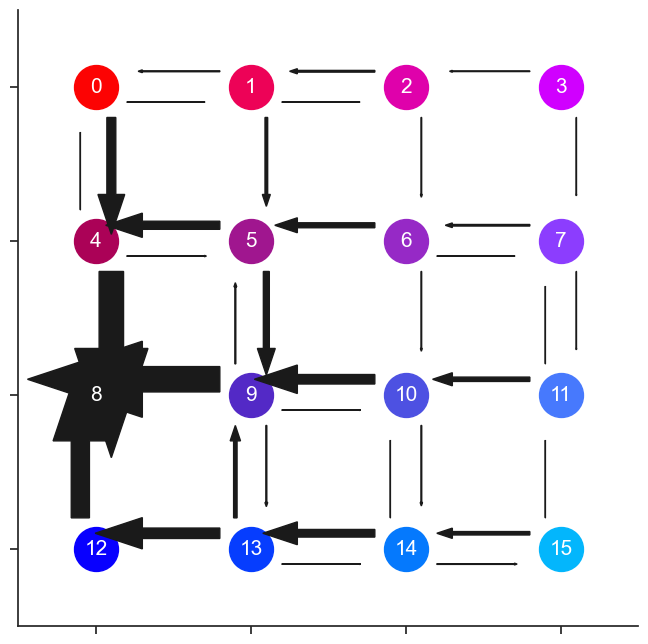

In [125]:
temp = beh.query("(prenode>-1)&(target==8)").copy()
temp['trans_count'] = temp.groupby(['node','prenode']).transform('size')  
temp['trans_freq'] = temp['trans_count']/len(temp)
transitions = temp[['prenode','node','trans_freq']].drop_duplicates()
plot_graph(transitions)

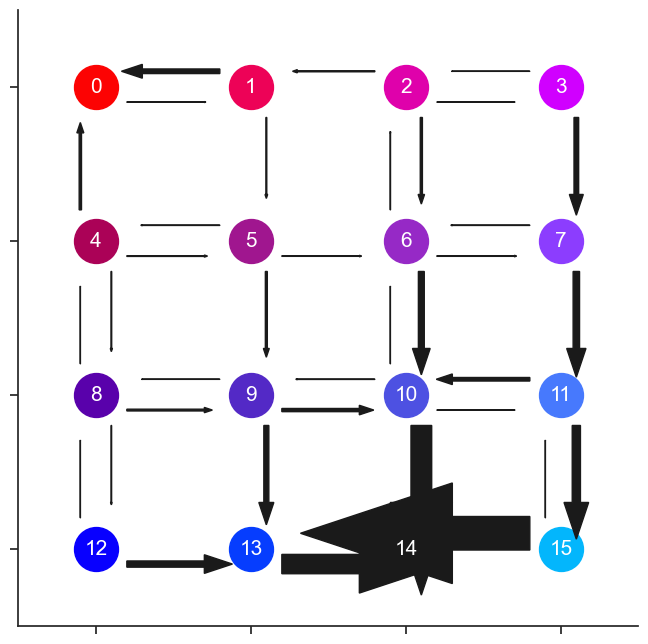

In [127]:
temp = beh.query("(prenode>-1)&(target==14)").copy()
temp['trans_count'] = temp.groupby(['node','prenode']).transform('size')  
temp['trans_freq'] = temp['trans_count']/len(temp)
transitions = temp[['prenode','node','trans_freq']].drop_duplicates()
plot_graph(transitions)

In [ ]:
# transitions will be goal dependent